# ODE-filters only

Let's find the fastest solver of the Lotka--Volterra problem, a standard benchmark problem. It is low-dimensional, not stiff, and generally poses no major problems for any numerical solver.

In [1]:
import functools

import jax
import jax.experimental.ode
import jax.numpy as jnp
import matplotlib.pyplot as plt
from _benchmark_utils import (
    plot_config,
    print_info,
    workprecision_make,
    workprecision_plot,
)
from diffeqzoo import backend, ivps
from jax import config

from odefilter import controls, cubature, ivpsolve, solvers
from odefilter.implementations import batch, dense, isotropic
from odefilter.strategies import filters, smoothers

# x64 precision
config.update("jax_enable_x64", True)

# CPU
config.update("jax_platform_name", "cpu")

# IVP examples in JAX
if not backend.has_been_selected:
    backend.select("jax")

# Nice-looking plots
plt.rcParams.update(plot_config())

# Which version of the softwares are we using?
print_info()

odefilter version:
	0.0.1a1
Most recent commit:
	b'cfe950\n'

jax:    0.3.23
jaxlib: 0.3.22
numpy:  1.23.3
python: 3.8.10 (default, Jun 22 2022, 20:18:18)  [GCC 9.4.0]
jax.devices (1 total, 1 local): [CpuDevice(id=0)]
process_count: 1


This is the ODE problem:

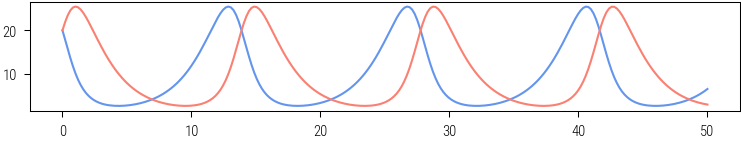

In [2]:
# Make a problem
f, u0, (t0, t1), f_args = ivps.lotka_volterra(time_span=(0.0, 50.0))
ODE_NAME = "Lotka-Volterra"


@jax.jit
def vf(x, *, t, p):
    return f(x, *p)


# Compile
vf(u0, t=t0, p=f_args)

ts = jnp.linspace(t0, t1, num=250)
odeint_solution = jax.experimental.ode.odeint(
    lambda u, t, *p: vf(u, t=t, p=p), u0, ts, *f_args, atol=1e-12, rtol=1e-12
)
ys_reference = odeint_solution[-1, :]

fig, ax = plt.subplots(figsize=(5, 1))
ax.plot(ts, odeint_solution, marker="None")
plt.show()

## Internal solvers
Let's start with finding the fastest ODE filter.


In [3]:
def solver_to_solve(solver, **kwargs):
    return jax.jit(functools.partial(_solve, solver=solver))


def _solve(*, solver, tol):
    solution = ivpsolve.simulate_terminal_values(
        vf,
        initial_values=(u0,),
        t0=t0,
        t1=t1,
        parameters=f_args,
        solver=solver,
        atol=1e-3 * tol,
        rtol=tol,
        control=controls.ProportionalIntegral(),
    )
    diff = (solution.u - ys_reference) / (1e-5 + ys_reference)
    return jnp.linalg.norm(diff) / jnp.sqrt(diff.size)


ode_dimension = u0.shape[0]

tolerances = 0.1 ** jnp.arange(1.0, 11.0, step=2.0)

workprecision_diagram = functools.partial(
    workprecision_make, number=3, repeat=3, tols=tolerances
)

### Which mode of linearization?

Should we linearize with a Taylor-approximation or by moment matching?

In [4]:
def correction_to_solver(implementation):
    solver = solvers.MLESolver(strategy=filters.Filter(implementation=implementation))
    return solver_to_solve(solver)


num_derivatives = 4
ts1 = dense.TS1.from_params(ode_dimension=ode_dimension)
mm1_sci = dense.MM1.from_params(
    ode_dimension=ode_dimension,
    num_derivatives=num_derivatives,
    cubature=cubature.SphericalCubatureIntegration.from_params(
        ode_dimension=ode_dimension
    ),
)

mm1_ut = dense.MM1.from_params(
    ode_dimension=ode_dimension,
    num_derivatives=num_derivatives,
    cubature=cubature.UnscentedTransform.from_params(
        ode_dimension=ode_dimension, r=1.0
    ),
)

mm1_gh = dense.MM1.from_params(
    ode_dimension=ode_dimension,
    num_derivatives=num_derivatives,
    cubature=cubature.GaussHermite.from_params(ode_dimension=ode_dimension, degree=3),
)


ts1_solver = correction_to_solver(ts1)
mm1_sci_solver = correction_to_solver(mm1_sci)
mm1_ut_solver = correction_to_solver(mm1_ut)
mm1_gh_solver = correction_to_solver(mm1_gh)

solve_fns = [
    (ts1_solver, f"TS1({num_derivatives})"),
    (mm1_sci_solver, f"MM1({num_derivatives}, SCI)"),
    (mm1_ut_solver, f"MM1({num_derivatives}, UT)"),
    (mm1_gh_solver, f"MM1({num_derivatives}, GH)"),
]

In [5]:
%%time

results = workprecision_diagram(solve_fns=solve_fns)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.81s/it]

CPU times: user 11.6 s, sys: 61.3 ms, total: 11.6 s
Wall time: 11.2 s


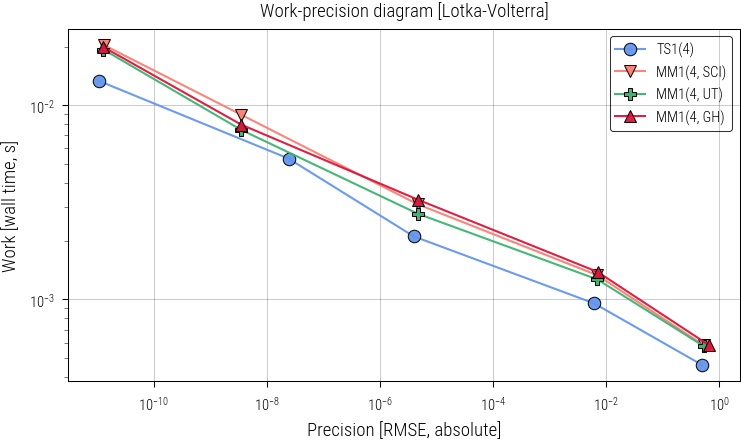

In [6]:
fig, ax = plt.subplots(figsize=(5, 3))
fig, ax = workprecision_plot(results=results, fig=fig, ax=ax, ode_name=ODE_NAME)
plt.show()

The Taylor-series based method is more efficient. The cubature rule has little effect on the efficiency of the moment-matching solver.

### Which factorisation?

What is the performance difference between an `IsoTaylorZerothOrder`, a `BatchTaylorZerothOrder`, and a `TaylorZerothOrder`?

In [7]:
def solver(implementation):
    return solver_to_solve(
        solvers.MLESolver(strategy=filters.Filter(implementation=implementation))
    )


num_derivatives = 4
iso_solver = solver(isotropic.IsoTS0.from_params(num_derivatives=num_derivatives))
batch_solver = solver(
    batch.BatchTS0.from_params(
        ode_dimension=ode_dimension, num_derivatives=num_derivatives
    )
)
dense_solver = solver(
    dense.TS0.from_params(ode_dimension=ode_dimension, num_derivatives=num_derivatives)
)


solve_fns = [
    (iso_solver, f"IsoTS0({num_derivatives})"),
    (batch_solver, f"BatchTS0({num_derivatives})"),
    (dense_solver, f"TS0({num_derivatives})"),
]

In [8]:
%%time

results = workprecision_diagram(solve_fns=solve_fns)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.45s/it]

CPU times: user 7.6 s, sys: 34.7 ms, total: 7.64 s
Wall time: 7.34 s


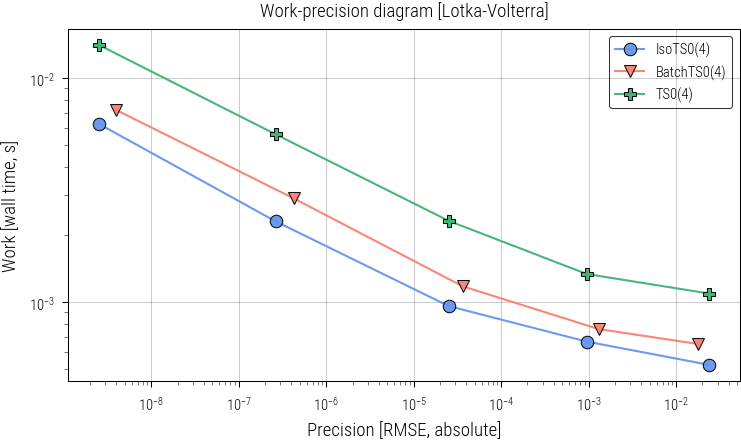

In [9]:
fig, ax = plt.subplots(figsize=(5, 3))
fig, ax = workprecision_plot(results=results, fig=fig, ax=ax, ode_name=ODE_NAME)
plt.show()

Unsurprisingly, the stronger the factorisation, the faster. The isotropic solver is the fastest, the batch-solver is second place, and the dense solver is the slowest (by far).
The isotropic solver and the dense solver actually compute the same posterior (the errors are vertically aligned), but at different speeds.

### Dynamic solvers or MLE solvers?

Are there differences between dynamic solvers and MLE solvers in terms of performance?
Let's try a comparison for high-order and low-order methods.

In [10]:
def strategy_to_dynamic_solver(strategy):
    return solver_to_solve(solvers.DynamicSolver(strategy=strategy))


def strategy_to_mle_solver(strategy):
    return solver_to_solve(solvers.MLESolver(strategy=strategy))


filter_ts0_iso_low = filters.Filter(
    implementation=isotropic.IsoTS0.from_params(num_derivatives=2)
)
filter_ts0_iso_medium = filters.Filter(
    implementation=isotropic.IsoTS0.from_params(num_derivatives=3)
)
filter_ts0_iso_high = filters.Filter(
    implementation=isotropic.IsoTS0.from_params(num_derivatives=5)
)

filter_ts1_low = filters.Filter(
    implementation=dense.TS1.from_params(ode_dimension=ode_dimension, num_derivatives=3)
)
filter_ts1_medium = filters.Filter(
    implementation=dense.TS1.from_params(ode_dimension=ode_dimension, num_derivatives=5)
)
filter_ts1_high = filters.Filter(
    implementation=dense.TS1.from_params(ode_dimension=ode_dimension, num_derivatives=8)
)


solve_fns = []
for strat, label in [
    (filter_ts0_iso_low, "IsoTS0(2)"),
    (filter_ts0_iso_medium, "IsoTS0(3)"),
    (filter_ts0_iso_high, "IsoTS0(5)"),
    (filter_ts1_low, "TS1(3)"),
    (filter_ts1_medium, "TS1(5)"),
    (filter_ts1_high, "TS1(8)"),
]:
    dynamic_solver = strategy_to_dynamic_solver(strat)
    mle_solver = strategy_to_mle_solver(strat)
    solve_fns.append(
        [
            (dynamic_solver, f"DynamicSolver({label})"),
            (mle_solver, f"MLESolver({label})"),
        ]
    )

In [11]:
%%time

results_all = [workprecision_diagram(solve_fns=fns) for fns in solve_fns]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:16<00:00,  8.22s/it]

CPU times: user 40.6 s, sys: 309 ms, total: 40.9 s
Wall time: 38.7 s


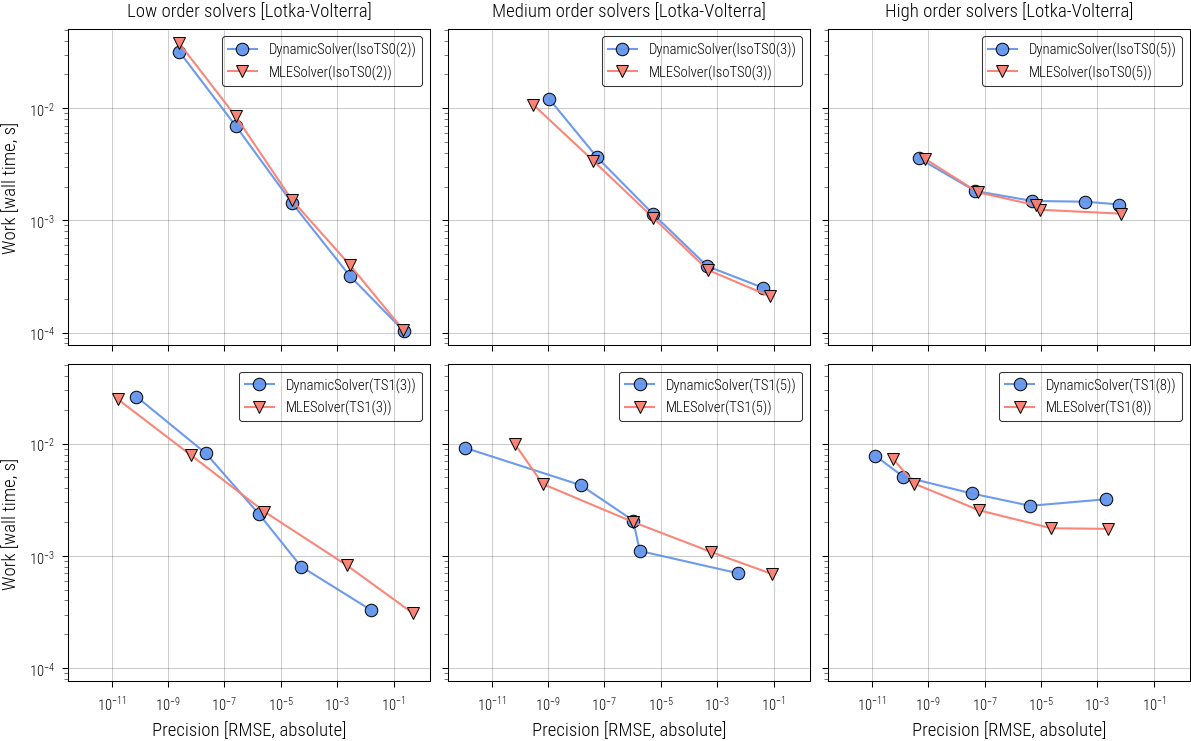

In [12]:
fig, axes = plt.subplots(figsize=(8, 5), nrows=2, ncols=3, sharex=True, sharey=True)

for ax, results in zip(axes.reshape((-1,)), results_all):
    fig, ax = workprecision_plot(
        results=results, fig=fig, ax=ax, title=None, xlabel=None, ylabel=None
    )

for ax in axes:
    ax[0].set_ylabel("Work [wall time, s]")

for ax, string in zip(axes.T, ["Low order", "Medium order", "High order"]):
    ax[0].set_title(f"{string} solvers [{ODE_NAME}]")
    ax[1].set_xlabel("Precision [RMSE, absolute]")
plt.show()

For zeroth-order Taylor series, the choice between dynamic and non-dynamic solvers is fairly irrelevant (the non-dynamic solver seems to have a sliiiiiight edge over the dynamic solver, but that is not very apparent).
For first-order Taylor series, non-dynamic calibration is better, but the difference is minimal for low-order methods and low precision.

### Should I use a filter or a smoother?

In [13]:
filter_solver = solver_to_solve(
    solvers.MLESolver(strategy=filters.Filter.from_params())
)
smoother_solver = solver_to_solve(
    solvers.MLESolver(strategy=smoothers.Smoother.from_params())
)
fixpt_smoother_solver = solver_to_solve(
    solvers.MLESolver(strategy=smoothers.FixedPointSmoother.from_params())
)

solve_fns = [
    (filter_solver, "Filter()"),
    (smoother_solver, "Smoother()"),
    (fixpt_smoother_solver, "FixedPointSmoother()"),
]

In [14]:
%%time

results = workprecision_diagram(solve_fns=solve_fns)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.92s/it]

CPU times: user 9.08 s, sys: 22 ms, total: 9.1 s
Wall time: 8.75 s


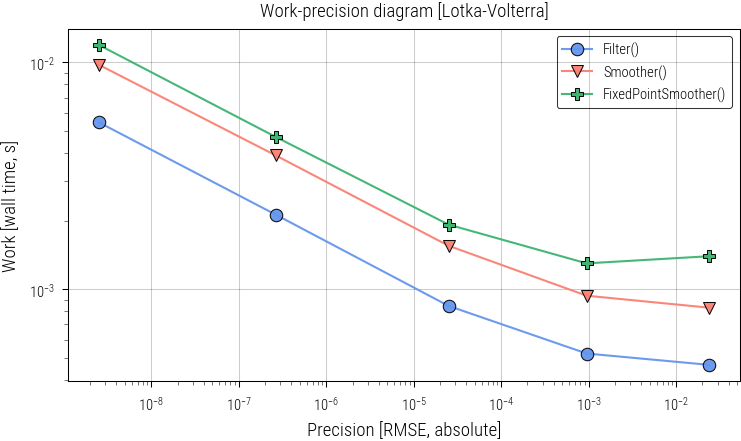

In [15]:
fig, ax = plt.subplots(figsize=(5, 3))
fig, ax = workprecision_plot(results=results, fig=fig, ax=ax, ode_name=ODE_NAME)
plt.show()

The filter is the fastest, the smoother is second, and the fixed-point smoother is the slowest.
But this is unsurprising, because the smoother and the fixed-point smoother compute extra quantities that the filter ignores.
These extra quantities make the smoothing solutions a valid posterior distribution at all time-points, whereas the filtering distribution makes sense mostly at the terminal value.

But when the quantitity of interest is the terminal value, filters are the go-to strategy.



### Fastest methods

So what are the fastest solvers?
We know that filters are better than smoothers for terminal-value simulation.
We also know that isotropic, zeroth-order approximations are the fastest zeroth-order methods,
and that Taylor-series based linearisations outperform moment matching.
We know that the dynamic solver is superior over the non-dynamic solver for low order methods with first-order linearisation, and that the is preferrable in the other setups (sometimes only incrementally).

Let's compare the winning solvers to find the best one.

In [22]:
def strategy_to_dynamic_solver(strategy):
    return solver_to_solve(solvers.DynamicSolver(strategy=strategy))


def strategy_to_mle_solver(strategy):
    return solver_to_solve(solvers.MLESolver(strategy=strategy))


num_low, num_medium, num_high = 3, 5, 8

ts0_iso_low = filters.Filter(
    implementation=isotropic.IsoTS0.from_params(num_derivatives=num_low)
)
ts0_iso_medium = filters.Filter(
    implementation=isotropic.IsoTS0.from_params(num_derivatives=num_medium)
)

ts1_low = filters.Filter(
    implementation=dense.TS1.from_params(
        ode_dimension=ode_dimension, num_derivatives=num_low
    )
)
ts1_medium = filters.Filter(
    implementation=dense.TS1.from_params(
        ode_dimension=ode_dimension, num_derivatives=num_medium
    )
)
ts1_high = filters.Filter(
    implementation=dense.TS1.from_params(
        ode_dimension=ode_dimension, num_derivatives=num_high
    )
)


mm1_high = filters.Filter(
    implementation=dense.MM1.from_params(
        ode_dimension=ode_dimension, num_derivatives=num_high
    )
)

solve_fns = [
    (strategy_to_mle_solver(ts0_iso_low), f"IsoTS0({num_low}), MLE"),
    (strategy_to_mle_solver(ts0_iso_medium), f"IsoTS0({num_medium}), MLE"),
    (strategy_to_dynamic_solver(ts1_low), f"TS1({num_low}), Dynamic"),
    (strategy_to_mle_solver(ts1_medium), f"TS1({num_medium}), MLE"),
    (strategy_to_mle_solver(ts1_high), f"TS1({num_high}), MLE"),
    (strategy_to_mle_solver(mm1_high), f"MM1({num_high}), MLE"),
]

In [23]:
%%time

results = workprecision_diagram(solve_fns=solve_fns)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:28<00:00,  4.68s/it]

CPU times: user 29.7 s, sys: 192 ms, total: 29.9 s
Wall time: 28.1 s


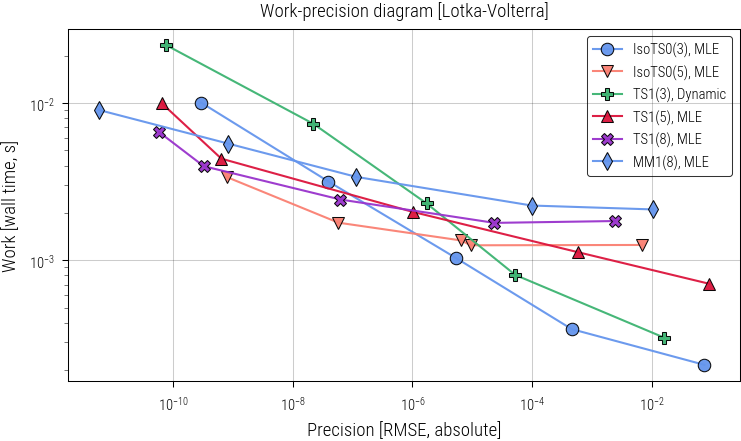

In [24]:
fig, ax = plt.subplots(figsize=(5, 3))
fig, ax = workprecision_plot(results=results, fig=fig, ax=ax, ode_name=ODE_NAME)

plt.show()

## Conclusion

If these results show one thing, then the fact that it is worth building a specialised ODE solver
for simulate_terminal_values(). The smoothing-based solvers compute extra factors that are just not needed for terminal-value simulation, and the extra factors turn out to be quite expensive. Every smoother was slower than its filtering-equivalent.

We can observe more:
* Dynamic calibration seems to perform at most as good as non-dynamic calibration. (Except for low order, low-precision EKF1, where the dynamic calibration seems to help. But even with the dynamic calibration is the low-order EKF1 one of the slowest solvers.)
* Low precision is best achieved with an isotropic EKF0(3). High precision is best achieved with an EKF1(8). The middle ground is better covered by an isotropic EKF0(5) than an EKF1(5).
* The cubature filters are more expensive than the extended filters (because cubature-linearisation costs more than Taylor-linearisation)